# TopoCluster Regression: IQR Comparison (for energy *scaling* networks)

This notebook makes plots of energy resolution (defined by the interquartile range for distributions of the ratio of predicted energy to calibration hits), specifically for regression networks that predict a *corrective factor* with which to multiply the reco energy (to get a predicted energy). This is in contrast with our "typical" regression networks that directly try to predict the energy itself.

In [1]:
# energy_bin_edges = [0.,5.,10.,25.,100.,300.,800.,1000.] # split_0
#energy_bin_edges = [0.,1.,2.,5.,10.,100.,1000.] # split_1
#energy_bin_edges = [0.,0.5,1.,1.5,2.,5.,10.,1000.] # split_2
#energy_bin_edges = [0.,1.,10.,1000.] # split_3
#energy_bin_edges = [0.,1.,10.,20.,50.] # split_4
#energy_bin_edges = [0.,1.,2.,5.,10.,20.,30.] # split_5
energy_bin_edges = [0.,60.] # split_6 (single bin)

In [2]:
# source & subdir -- used to specify a set of networks that were trained with particular data & settings
source = 'split_6'
subdirs = ['e{}'.format(i) for i in range(len(energy_bin_edges)-1)]
n_splits = len(subdirs)

#### 1) Initial setup

In [3]:
# Import some basic libraries.
import sys, os, glob
import numpy as np
import h5py as h5
import ROOT as rt # used for plotting
import matplotlib.pyplot as plt

# Import our resolution utilities
path_prefix = os.getcwd() + '/../'
if(path_prefix not in sys.path): sys.path.append(path_prefix)
from util import plot_util       as pu
from util import ml_util         as mu
from util import qol_util        as qu

# regression-specific imports
from util.regression import plot_util as rpu

rt.gStyle.SetOptStat(0)
plotstyle = qu.PlotStyle('dark')
plotstyle.SetStyle()

plotpath = os.getcwd() + '/Plots/'
modelpaths = [os.getcwd() + '/Models/{}/{}/'.format(source,subdir) for subdir in subdirs]

try: os.makedirs(plotpath)
except: pass

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]
cell_shapes = {layers[i]:(len_eta[i],len_phi[i]) for i in range(len(layers))}

Welcome to JupyROOT 6.24/02


2021-07-28 09:18:12.571995: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [4]:
pi_latex = {
    'p0': '$\pi^0$',
    'pp': '$\pi^\pm$',
}

#### 2) Get Results

Rather than get the data, networks & re-evaluate everything, we're just going to load network outputs from HDF5 files that were saved during training & evaluation in our training notebook. This means that this notebook should run rather quickly (and not require GPU resources for quick network evaluation). Just make sure not to throw out the HDF5 files with results, otherwise you will have to remake them with the other notebook.

In [5]:
def TColor2RGB(color_index):
    color = rt.gROOT.GetColor(color_index)
    return (color.GetRed(), color.GetGreen(), color.GetBlue())

In [17]:
# list of networks to evaluate
models     = ['all','simple','simple_cnn','split_emb_cnn']
colors     = [rt.kRed, rt.kYellow+1, rt.kCyan, rt.kGreen, plotstyle.curve] # add rt.kPink+9 for resnet

#models = ['split_emb_cnn']
#colors = [rt.kGreen, plotstyle.curve]

colors_plt = [TColor2RGB(c) for c in colors]

In [18]:
# unlike in our standard approach, different instances of each model were trained on different energy bins, so we will load multiple sets of results per network, one for each energy bin.
result_files = {
    model:{
        'pp':[h5.File(mp + '{}/{}_charged_output.h5'.format(model,model),'r') for mp in modelpaths],
        'p0':[h5.File(mp + '{}/{}_neutral_output.h5'.format(model,model),'r') for mp in modelpaths]
    }
    for model in models
}

In [19]:
results = {
    model:{
        key:{
            name:[file[name][file['test'][:]] for file in file_list]
            for name in ['output','truth','reco']
        }
        for key,file_list in result_files[model].items()
    }
    for model in models
}

In [20]:
results_agg = {
    model:{
        key:{
            name:np.concatenate(results[model][key][name])
            for name in ['output','truth','reco']
        }
        for key,file_list in result_files[model].items()
    }
    for model in models
}

In [21]:
for fdict in result_files.values():
    for key,file_list in fdict.items():
        for file in file_list: file.close()

#### 3) Make IQR plots (with ROOT)

**TODO**: Try using some of our custom (matplotlib-based) functions. Maybe the plots will look nice?

In [22]:
bin_width = .5 # GeV (2.5 for split_0)
nbins = int(energy_bin_edges[-1] / bin_width)
x_range = (energy_bin_edges[0], energy_bin_edges[-1])

In [23]:
iqr_hists = {
    model:{
        key: [rpu.IqrPlot(e1 = data['output'][i] * data['reco'][i], # ratio numerator (prediction)
                          e2 = data['truth'][i], # ratio denominator (truth)
                          e3 = data['reco'][i], # bin by reco energy, not truth
                          nbins = nbins, x_range=x_range, normalize=True) 
              for i in range(n_splits)] 
        for key,data in results[model].items()
    }
    for model in models
}

# explicitly add IQR histograms for reco
iqr_hists['reco'] = {
    key: [rpu.IqrPlot(e1 = data['reco'][i], # ratio numerator (reco)
                      e2 = data['truth'][i], # ratio denominator (truth)
                      e3 = data['reco'][i], # bin by reco energy, not truth
                      nbins = nbins, x_range=x_range, normalize=True)
          for i in range(n_splits)]
    for key,data in results[models[0]].items()
}

models_full = models + ['reco']

In [24]:
iqr_hists_agg = {
    model:{
        key: rpu.IqrPlot(e1 = data['output'] * data['reco'], # ratio numerator (prediction)
                          e2 = data['truth'], # ratio denominator (truth)
                          e3 = data['truth'], # bin by truth energy (can omit)
                          nbins = nbins, x_range=x_range, normalize=True) 
        for key,data in results_agg[model].items()
    }
    for model in models
}

# explicitly add IQR histograms for reco
iqr_hists_agg['reco'] = {
    key: rpu.IqrPlot(e1 = data['reco'], # ratio numerator (reco)
                      e2 = data['truth'], # ratio denominator (truth)
                      e3 = data['truth'], #bin by truth energy (can omit)
                      nbins = nbins, x_range=x_range, normalize=True)
    for key,data in results_agg[models[0]].items()
}

models_full = models + ['reco']

In [25]:
bin_edges = np.linspace(*x_range, nbins+1)
bin_centers = np.array([np.mean([bin_edges[i],bin_edges[i+1]]) for i in range(nbins)])

The `ROOT` histograms are convenient containers for our data. However, in this case I think it is easiest to plot things with `matplotlib`, since we're plotting segments of histograms on the same axis and we don't want to draw the zero-bins at all (or the edges leading to them). This seems easiest to accomplish with `matplotlib`.

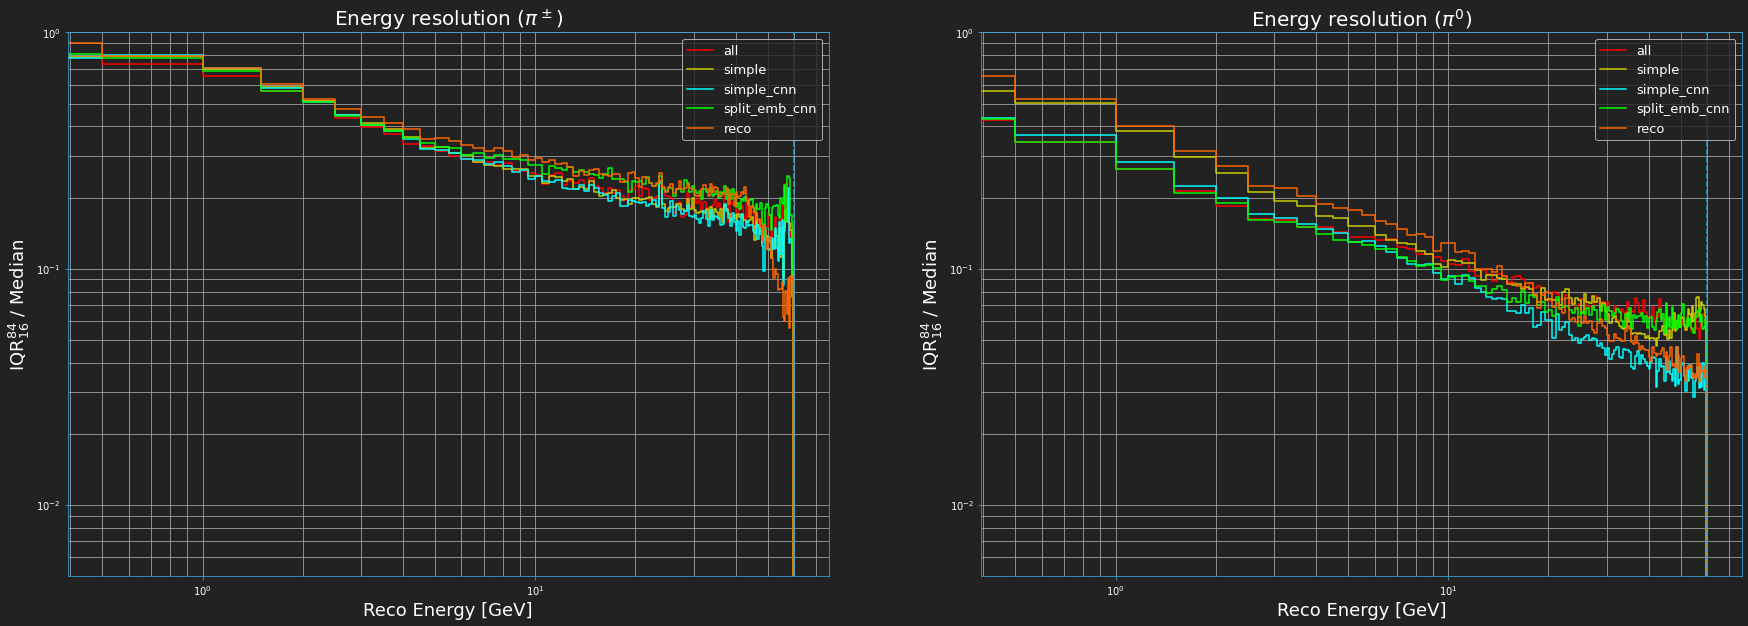

In [26]:
fig, axs = plt.subplots(1,2,figsize=(30,10))

for i,key in enumerate(['pp','p0']):
    ax = axs[i]
    plotstyle.SetStylePlt(ax)
    
    for j,model in enumerate(models_full):
        for k in range(n_splits):
            rhist = iqr_hists[model][key][k]
            edges = (energy_bin_edges[k],energy_bin_edges[k+1])
            
            # get all the y-values from the histogram -- includes the empty bins
            y_vals = np.array([rhist.GetBinContent(l+1) for l in range(nbins)])
            
            selected_indices = np.all(np.row_stack((bin_centers > edges[0], bin_centers < edges[1])),axis=0)
            y_vals = y_vals[selected_indices]

            # Option 1: plot bin centers
#             x_vals = bin_centers[selected_indices]
            
            # Option 2: Make this look like a binned histogram
            x_vals = bin_edges[:-1][selected_indices]
            next_bin = bin_edges[np.where(selected_indices == True)[0][-1] + 1]
            x_vals2 = np.append(x_vals[1:],next_bin)
            x_vals = np.vstack((x_vals,x_vals2)).reshape((-1,),order='F')            
            y_vals = np.vstack((y_vals,y_vals)).reshape((-1,),order='F')
            
            # --------------------------------
            # Visual aid: If this is far to the right, we can do some smoothing (averaging) as the x logscale
            # will cram things together. Not sure if we ultimately want to keep this, versus defining variable binning
            # for the IQR plots themselves
            avg_factor = 1
            if(edges[0] > 250.): avg_factor = 20
            elif(edges[0] > 9.): avg_factor = 10
                
            # make sure length is divisible, pad if needed (will have minimal effect)
            while(len(x_vals) % (2 * avg_factor) != 0): 
                x_vals = np.append(x_vals,x_vals[-1])
                y_vals = np.append(y_vals,y_vals[-1])                    

            x_vals = np.append(x_vals[::2 * avg_factor],x_vals[-1])
            x_vals = np.repeat(x_vals,2)[1:-1]

            y_vals = np.mean(y_vals.reshape(-1,2 * avg_factor), axis=1)
            y_vals = np.repeat(y_vals,2)
            # ---------------------------------
                
            label = None
            if(k == 0): label = model
            ax.plot(x_vals,y_vals, color=colors_plt[j],label=label)
         
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # draw the dividing lines showing the different bins -- make sure to fix the y limits
    #y_lim = ax.get_ylim()
    y_lim = (5.0e-3,1.0)
    for edge in energy_bin_edges: ax.plot((edge,edge),y_lim,color=TColor2RGB(plotstyle.main),linestyle='--')
    ax.set_ylim(y_lim)
    
    legend = ax.legend(facecolor=plotstyle.canv_plt,loc='upper right')
    for leg_text in legend.get_texts(): leg_text.set_color(plotstyle.text_plt)
    
    ax.set_title('Energy resolution ({})'.format(pi_latex[key]), fontsize=20)
    ax.set_xlabel('Reco Energy [GeV]')
    ax.set_ylabel('IQR$^{84}_{16}$ / Median')
    ax.grid(True,which='both',color=plotstyle.grid_plt)
    
fig.patch.set_facecolor(plotstyle.canv_plt)
plt.savefig(plotpath + 'resolution.png',dpi=300)

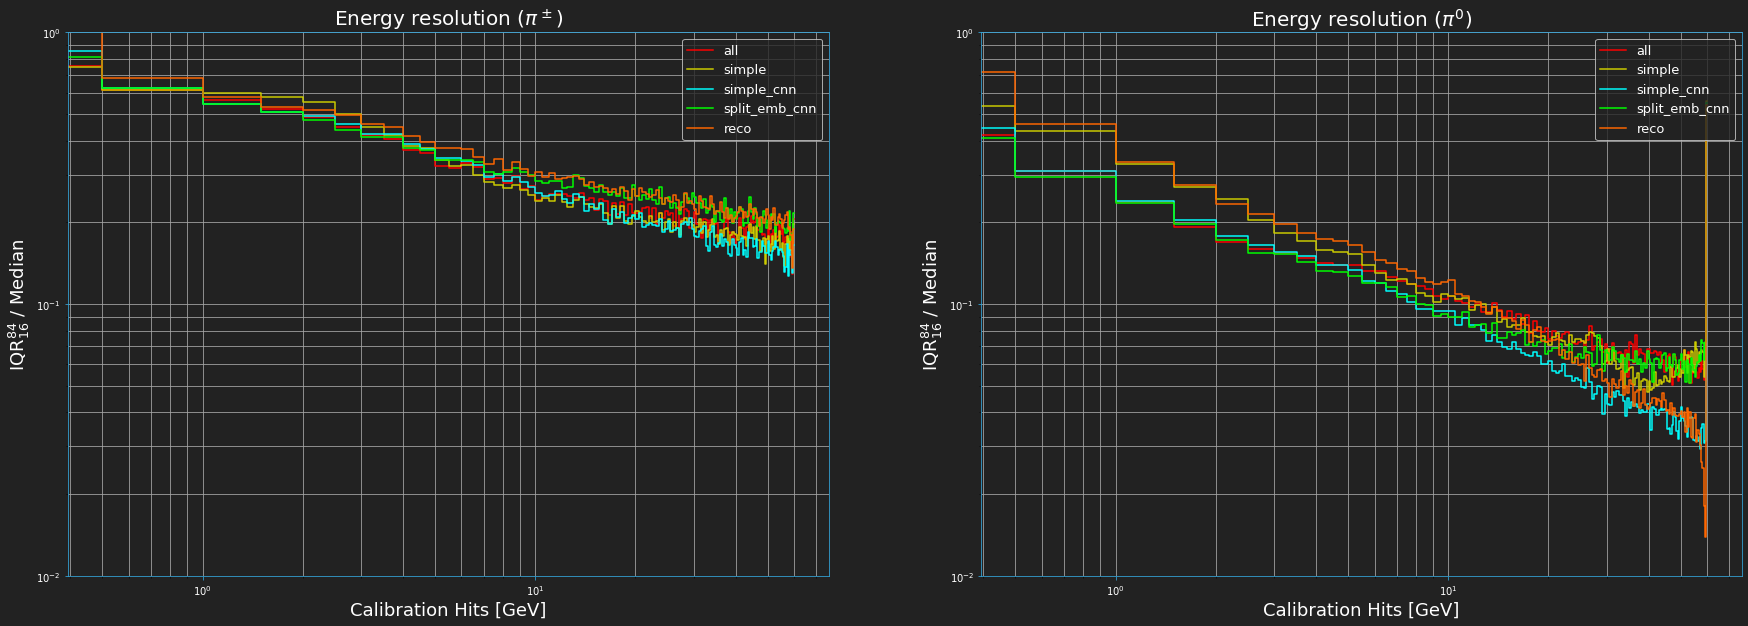

In [28]:
fig, axs = plt.subplots(1,2,figsize=(30,10))

for i,key in enumerate(['pp','p0']):
    ax = axs[i]
    plotstyle.SetStylePlt(ax)
    
    for j,model in enumerate(models_full):
        rhist = iqr_hists_agg[model][key]

        # get all the y-values from the histogram -- includes the empty bins
        y_vals = np.array([rhist.GetBinContent(l+1) for l in range(nbins)])

        x_vals = bin_edges
        x_vals = np.vstack((x_vals,x_vals)).reshape((-1,),order='F')[1:-1]           
        y_vals = np.vstack((y_vals,y_vals)).reshape((-1,),order='F')

        label = model
        ax.plot(x_vals,y_vals, color=colors_plt[j],label=label)
         
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # draw the dividing lines showing the different bins -- make sure to fix the y limits
    #y_lim = ax.get_ylim()
    #y_lim = (5.0e-3,1.0)
    y_lim = (1.0e-2,1.0)

    ax.set_ylim(y_lim)
    
    legend = ax.legend(facecolor=plotstyle.canv_plt,loc='upper right')
    for leg_text in legend.get_texts(): leg_text.set_color(plotstyle.text_plt)
    
    ax.set_title('Energy resolution ({})'.format(pi_latex[key]), fontsize=20)
    ax.set_xlabel('Calibration Hits [GeV]')
    ax.set_ylabel('IQR$^{84}_{16}$ / Median')
    ax.grid(True,which='both',color=plotstyle.grid_plt)
    
fig.patch.set_facecolor(plotstyle.canv_plt)
plt.savefig(plotpath + 'resolution2.png',dpi=300)